# Statistics

# import functions

In [351]:
#python functions
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from timeinfo import day_night
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter1d
import os, glob, datetime, gsw, cmocean, math
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from skbio.stats.ordination import cca

In [349]:
# R functions install one time enough
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

# utils.install_packages("vegan") done

<rpy2.rinterface_lib.sexp.NULLType object at 0x7f90fe232280> [RTYPES.NILSXP]

In [350]:
# Import R packages
vegan = rpackages.importr("vegan")
# vegan.__dict__['_rpy2r'] to see possible functions

# datafram conversion python to R
# Allow conversion
import rpy2.robjects as ro


# import data

In [181]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', 'all', 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()]


# Hydrography data

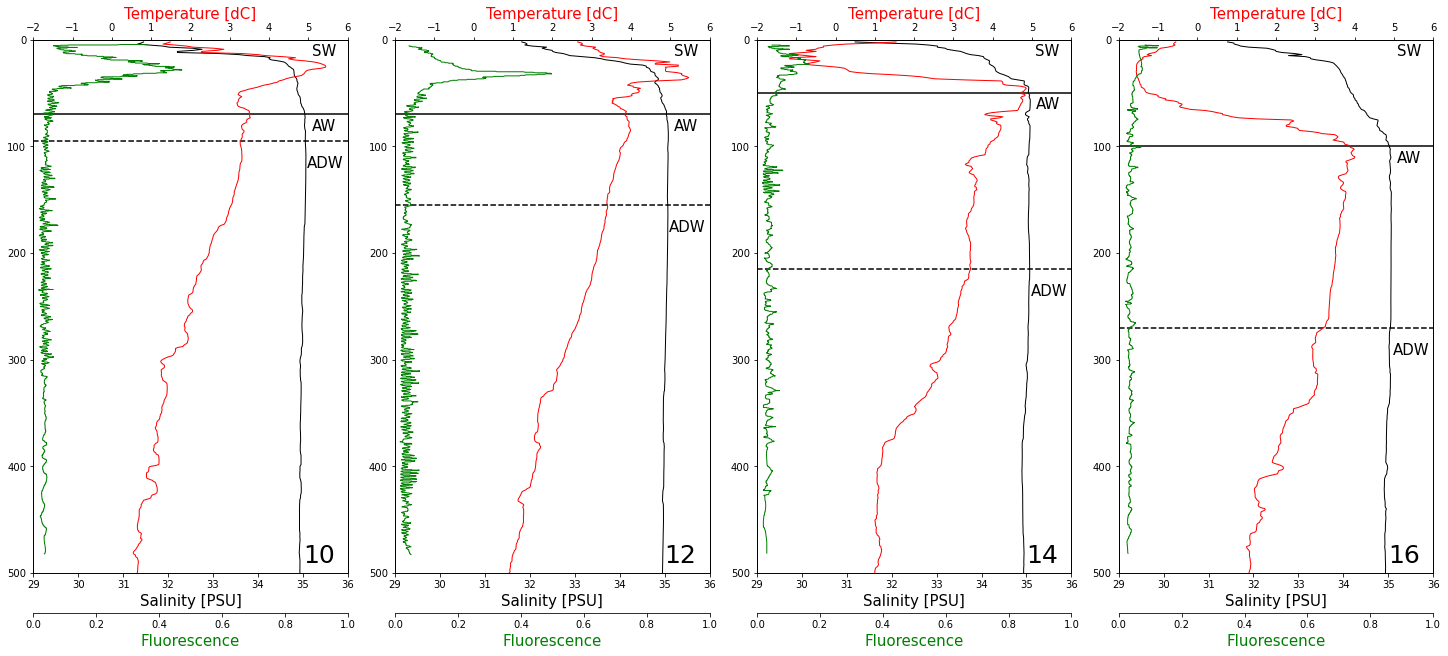

In [199]:
wm_dict = {'PS107_010-5': (70, 95), 'PS107_012-4': (70, 155), 'PS107_014-5': (50, 215), 'PS107_016-4': (100, 270)}
loki_stations = ('PS107_010-5', 'PS107_012-4', 'PS107_014-5', 'PS107_016-4')
loki_df_sel = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_stations))]

fig = plt.figure(constrained_layout=True, figsize =(20, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in loki_stations:
    up, down = wm_dict[i]
    cruise, station = i.split('_')[0], int(i.split('_')[1].split('-')[0])
    loki_station_df = loki_df_sel.loc[loki_df_sel['station'] == i]
    ctd_station_df = ctd_df.loc[ctd_df['Event'].str.contains(str(cruise+'_'+str(station)))]


    ax = fig.add_subplot(gs[0,n])
    ax.plot(tuple(pd.to_numeric(ctd_station_df['Sal'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='black', linewidth= 1)
    ax.set_xlabel('Salinity [PSU]', color = 'black', fontsize=15)
    ax.set_ylim(0,500)
    ax.set_xlim(29,36)

    sec_axs = ax.twiny()
    sec_axs.plot(tuple(pd.to_numeric(ctd_station_df['Temp [°C]'])), tuple(pd.to_numeric(ctd_station_df['Depth water [m]'])), color='red', linewidth= 1)
    sec_axs.set_xlim(-2,6)
    sec_axs.set_xlabel('Temperature [dC]', color = 'red', fontsize=15)

    
    thr_axs = ax.twiny()
    thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
    thr_axs.xaxis.set_ticks_position('bottom')
    thr_axs.xaxis.set_label_position('bottom')
    thr_axs.plot(gaussian_filter1d(loki_station_df['fluorescence'], sigma=10), loki_station_df['loki_depth'], color='green', linewidth= 1)
    thr_axs.set_xlabel('Fluorescence', color = 'green', fontsize=15)
    thr_axs.set_xlim(0,1)
    thr_axs.invert_yaxis()
    
    ax.text(35, 490, station, size=25)
    
    # water mass
    ax.axhline(y=up, color='black', ls='-')
    ax.axhline(y=down, color='black', ls='--')
    ax.text(35.2, 15, 'SW', size=15)
    ax.text(35.2, up+15, 'AW', size=15)
    ax.text(35.1, down+25, 'ADW', size=15)
    
    n += 1

plt.show()
plt.close()



# data pre-processing

In [228]:
# data processing for LOKI data
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']


sf_df = pd.DataFrame() # surface water mass df
aw_df = pd.DataFrame() # atlantic water mass df
adw_df = pd.DataFrame() # atlantic dense water mass df

for s in loki_stations:
    
    # count the sp with 5m depth bin
    each_st_df = loki_df_sel.loc[loki_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for d in range(0, math.ceil(max(each_st_df['loki_depth'])), 5):
        bin_df = each_st_df.loc[(each_st_df['loki_depth'] >= d) & (each_st_df['loki_depth'] < d+5)]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum
                count = bin_df['phylum'].loc[bin_df['phylum']==c].count()
                each_st_bin_df.loc[row, c] = count

            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df['class'].loc[bin_df['class']==c].count()
                each_st_bin_df.loc[row, c] = count
                
            else: # check onlyin col = genus
                count = bin_df['genus'].loc[bin_df['genus']==c].count()
                each_st_bin_df.loc[row, c] = count
        each_st_bin_df.loc[row, 'depth'] = d+5
        row += 1
    
    
    # add station number
    each_st_bin_df['station'] = s
    
    # move data to following water mass
    up, down = wm_dict[s]
    sf_df = sf_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=0) & (each_st_bin_df['depth']<up)])
    aw_df = aw_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=up) & (each_st_bin_df['depth']<down)])
    adw_df = adw_df.append(each_st_bin_df.loc[each_st_bin_df['depth']>=down])
    
    
    
    
sf_df.reset_index(drop=True, inplace = True)
aw_df.reset_index(drop=True, inplace = True)
adw_df.reset_index(drop=True, inplace = True)

sf_df['tag'] = 'surface'
aw_df['tag'] = 'atlantic'
adw_df['tag'] = 'atlantic_dense'

all_df = pd.concat([sf_df, aw_df, adw_df], ignore_index=True)

In [101]:
# data processing for Particle data
isc_stations = ('PS107_10_3', 'PS107_12_2', 'PS107_14_7', 'PS107_16_2')
isc_sel_stb = isc_stb.loc[isc_stb['cruise_station_haul'].str.contains('|'.join(isc_stations))]


isc_all_df = pd.DataFrame(columns=['cruise_station_cast','lat', 'lon', 'depth', 'temp', 'sal','turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
for index, value in isc_sel_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, cast, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), str(value['cruise_station_haul'].split('_')[2]),int(float(value['profile_number']))
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            lat, lon = value['lat'], value['lon']
            particle_range = [150, 500, 1000, 100000] # micro meter
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 5, particle_range, 'processed')
            df = pd.DataFrame(columns=['lat', 'lon', 'depth', 'temp', 'sal', 'turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
            df['depth'], df['sal'], df['temp']  = isc_ctd_df['Depths (m)'], isc_ctd_df['Salinity (PSU)'], isc_ctd_df['Temperature (dC)']
            df['turb'], df['fluo'] = isc_ctd_df['Turbidity (NTU)'], isc_ctd_df['Fluorescence (mg/m3)']
            df['ctd_total_vol'], df['ctd_total_abd'] = isc_ctd_df['Total Aggregate Volume (ppm)'], isc_ctd_df['Aggregate abundance (#/l)']
            df['med_ESD'], df['avg_ESD'] = isc_ctd_df['Median ESD (µm)'], isc_ctd_df['Average ESD (µm)']
            df['vol_150-500'], df['vol_500-1000'], df['vol_total'] = vol_spec_df['150-500'], vol_spec_df['500-1000'], vol_spec_df['total']
            df['abd_150-500'], df['abd_500-1000'], df['abd_total'] = aggr_con_df['150-500'], aggr_con_df['500-1000'], aggr_con_df['total']
            df['lat'], df['lon'] = lat, lon
            df['cruise_station_cast'] = str(cruise) +'_'+ str(station) +'_'+ str(cast)
            
            isc_all_df = isc_all_df.append(df, ignore_index=True)

isc_all_df = isc_all_df.dropna()

In [102]:
# tag water mass name on the particle data frame
wm_isc_dict = {'PS107_10_3': (70, 95), 'PS107_12_2': (70, 155), 'PS107_14_7': (50, 215), 'PS107_16_2': (100, 270)}

for key in wm_isc_dict:
    up, down = wm_isc_dict[key]
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>0) & (isc_all_df['depth']<=up) ,'tag'] = 'surface'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>up) & (isc_all_df['depth']<=down) ,'tag'] = 'atlantic'
    isc_all_df.loc[(isc_all_df['cruise_station_cast']==key) & (isc_all_df['depth']>down),'tag'] = 'atlantic_dense'


# vertical distribution, both Paticle and Zooplankton

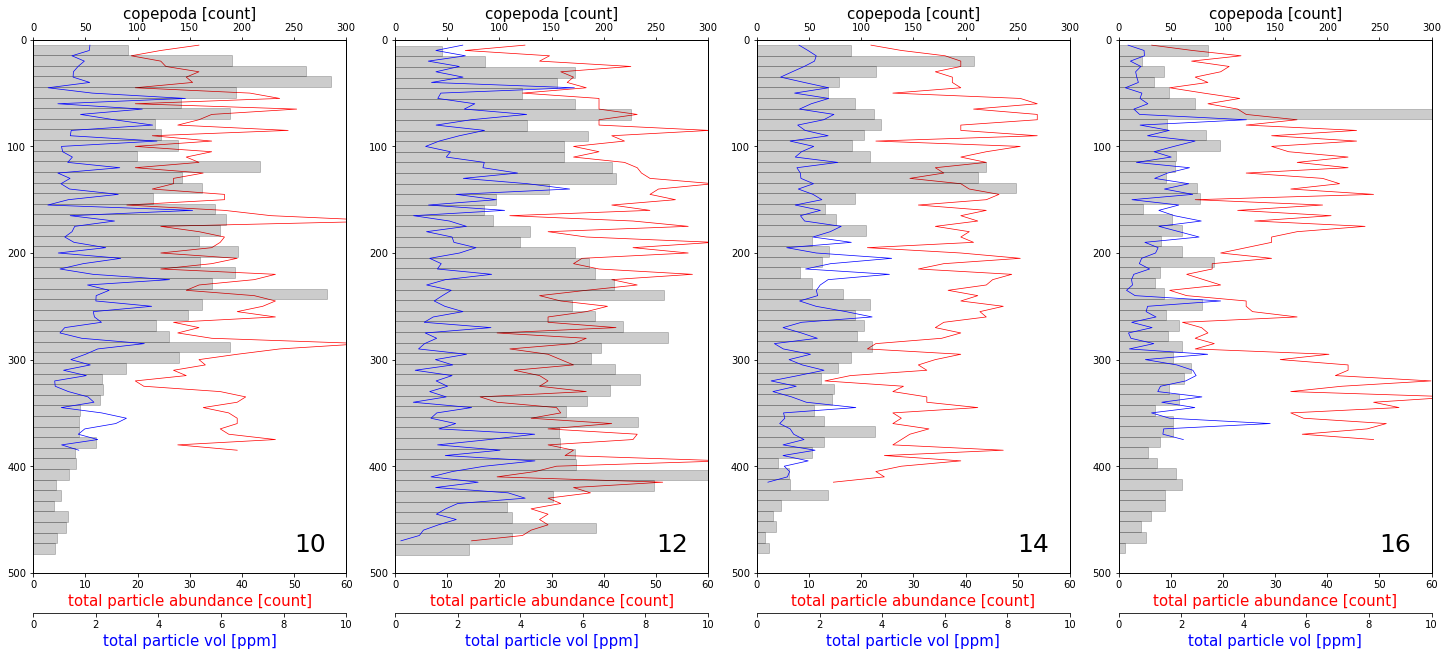

In [229]:
# Based on the cruise and profilenumber of ISC, import data from excel file
fig = plt.figure(constrained_layout=True, figsize =(20, 9))
gs = fig.add_gridspec(1, 4)

n = 0
for i in isc_stations:
    cruise, station = i.split('_')[0], i.split('_')[1]
    #  from here specific station
    isc_station_df = isc_all_df.loc[isc_all_df['cruise_station_cast'] == i]
    loki_station_df = loki_df[loki_df['station'].str.contains(cruise+'_'+str(station).zfill(3)) & loki_df['animal']==True] # select corresponding loki station
    
    copepoda_df = loki_station_df[loki_station_df['copepod']==True] # df only for copepoda
    copepoda_depth = copepoda_df['loki_depth'].to_list()
    
    ax = fig.add_subplot(gs[0,n])
    ax.plot(isc_station_df['abd_total'], isc_station_df['depth'], color='red', linewidth= 0.7)
    ax.set_xlabel('total particle abundance [count]', color = 'red', fontsize=15)
    ax.set_ylim(0,500)
    ax.set_xlim(0,60)

    sec_axs = ax.twiny()
    sec_axs.hist(copepoda_depth, orientation='horizontal', bins = int(max(copepoda_depth)/10), edgecolor='black', alpha=0.2, color='black')
    sec_axs.set_xlim(0,300)
    sec_axs.set_xlabel('copepoda [count]', color = 'black', fontsize=15)


    thr_axs = ax.twiny()
    thr_axs.spines['bottom'].set_position(('outward', 40))  # make new outmost axis                  
    thr_axs.xaxis.set_ticks_position('bottom')
    thr_axs.xaxis.set_label_position('bottom')
    thr_axs.plot(isc_station_df['vol_150-500']+isc_station_df['vol_500-1000'], isc_station_df['depth'], color='blue', linewidth= 0.7)
    thr_axs.set_xlabel('total particle vol [ppm]', color = 'blue', fontsize=15)
    thr_axs.set_xlim(0,10)
    thr_axs.invert_yaxis()
    
    ax.text(50, 480, station, size=25)
    
    n += 1

plt.show()
plt.close()


# Linear Discriminant analysis

Particle


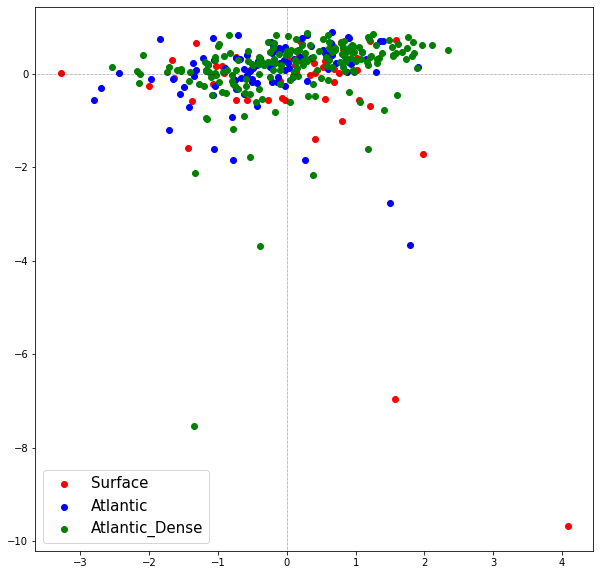

In [391]:
# LOKI zooplankton
# normalise data

isc_sel_df = isc_all_df[['abd_150-500','abd_500-1000','abd_total', 'vol_150-500','vol_500-1000','vol_total','avg_ESD', 'tag']]
all_df_scaled = StandardScaler().fit_transform(isc_sel_df[['abd_total', 'vol_total', 'avg_ESD']])

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, isc_sel_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
print('Particle')
fig = plt.figure(figsize =(10, 10))


plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c='red', label='Surface')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c='blue', label='Atlantic')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c='green', label='Atlantic_Dense')

plt.legend(loc='lower left', fontsize=15)


plt.show()
plt.close()

Zooplankton


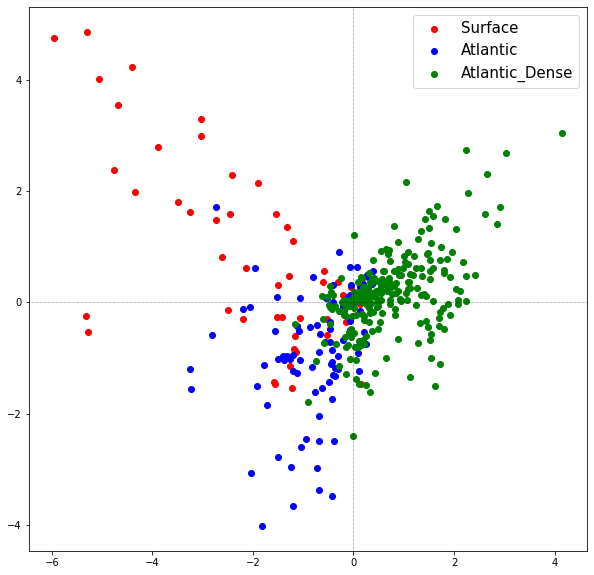

In [390]:
# LOKI zooplankton
# normalise data
all_df_scaled = StandardScaler().fit_transform(all_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']])


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, all_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']


# plot
print('Zooplankton')
fig = plt.figure(figsize =(10, 10))


plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c='red', label='Surface')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c='blue', label='Atlantic')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c='green', label='Atlantic_Dense')

plt.legend(loc='upper right', fontsize=15)



plt.show()
plt.close()

# CCA (Canonical Correspondense Analysis) 

In [326]:
all_df['st_wm'] = all_df['station']+'_'+all_df['tag']

loki_count_df = pd.DataFrame(columns=['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 
                                      'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto', 'st_wm'])


for st_wm in list(all_df['st_wm'].drop_duplicates()):
    st_wm_df = all_df.loc[all_df['st_wm']==st_wm]
    sumry = st_wm_df.drop( ['depth', 'tag', 'station','st_wm'], axis=1).sum()
    df = pd.DataFrame(sumry.values, index = sumry.index)
    df = df.T
    df['st_wm'] = st_wm
    loki_count_df =loki_count_df.append(df)
    
# water mass to numeber masking
sf_mask = loki_count_df['st_wm'].str.contains('surface')
aw_mask = loki_count_df['st_wm'].str.contains('atlantic') & ~loki_count_df['st_wm'].str.contains('atlantic_dense')
adw_mask = loki_count_df['st_wm'].str.contains('atlantic_dense')

loki_count_df['surface'] = sf_mask
loki_count_df['atlantic'] = aw_mask
loki_count_df['atlantic_dense'] = adw_mask

loki_count_df = loki_count_df.mask(loki_count_df == True, 1)
loki_count_df = loki_count_df.mask(loki_count_df == False, 0)

loki_count_df.reset_index(drop=True, inplace=True)
print(list(loki_count_df))

['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus', 'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto', 'st_wm', 'surface', 'atlantic', 'atlantic_dense']


CCA1     0.415593
CCA2     0.097176
CCA3     0.276265
CCA4     0.123247
CCA5     0.041465
CCA6     0.025409
CCA7     0.007606
CCA8     0.007135
CCA9     0.004262
CCA10    0.001161
CCA11    0.000681
dtype: float64


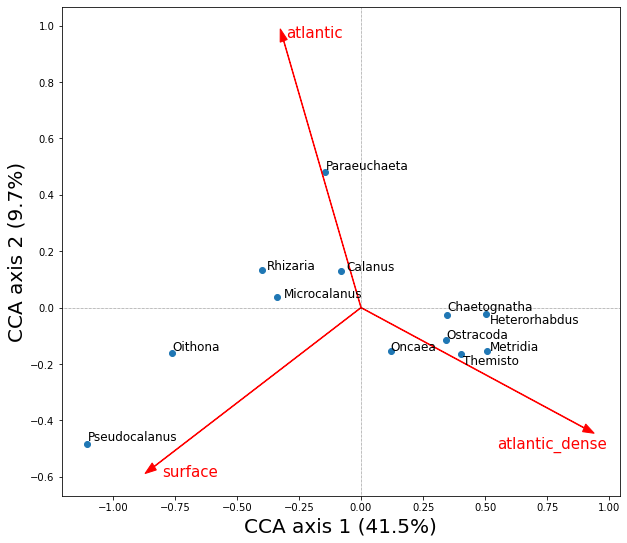

In [448]:
env_var = loki_count_df[['surface', 'atlantic', 'atlantic_dense']]
spp = loki_count_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus', 
                     'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']]

loki_cca = cca(spp, env_var, scaling=2)
spp_cca = loki_cca.features
wm_cca = loki_cca.biplot_scores


print(loki_cca.proportion_explained)

fig = plt.figure(figsize =(10, 9))

plt.axhline(y=0, color='black', ls='dotted', linewidth=0.5)
plt.axvline(x=0, color='black', ls='dotted', linewidth=0.5)

# draw water mass arrow
for i in range(0, len(wm_cca['CCA1'])):
    plt.arrow(0, 0, wm_cca['CCA1'][i], wm_cca['CCA2'][i], width= 0.002, head_width=0.03, color='red')

# add point of spp.
plt.scatter(spp_cca['CCA1'], spp_cca['CCA2'])


# add text
plt.text(0.347943, -0.01 , 'Chaetognatha' , size=12)
plt.text(-0.38, 0.134, 'Rhizaria' , size=12)
plt.text(0.342, -0.11, 'Ostracoda' , size=12)
plt.text(-0.06, 0.130817, 'Calanus' , size=12)
plt.text(0.52, -0.055, 'Heterorhabdus' , size=12)
plt.text(0.52, -0.15, 'Metridia' , size=12)
plt.text(-0.31, 0.037, 'Microcalanus' , size=12)
plt.text(-0.76, -0.15, 'Oithona' , size=12)
plt.text(0.12, -0.15, 'Oncaea' , size=12)
plt.text(-0.14, 0.49, 'Paraeuchaeta' , size=12)
plt.text(-1.1, -0.47, 'Pseudocalanus' , size=12)
plt.text(0.41, -0.2, 'Themisto' , size=12)

plt.text(-0.8, -0.6, 'surface' , size=15, color='red')
plt.text(-0.3, 0.96, 'atlantic' , size=15, color='red')
plt.text(0.55, -0.5, 'atlantic_dense' , size=15, color='red')

plt.xlabel('CCA axis 1 (41.5%)', size=20)
plt.ylabel('CCA axis 2 (9.7%)', size=20)


plt.show()
plt.close()